# Example Noise

Here we demonstrate an example noise analysis

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import numpy as np
import pandas as pd

import glob, json, os
import matplotlib.pyplot as plt

from h5pulsar import Pulsar, FilePulsar
from enterprise.signals import parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise.signals import utils

from dr3_noise.models import model_singlepsr_noise
from dr3_noise.model_utils import get_freqs
from dr3_noise.selections import CustomSelections
from enterprise_extensions.sampler import setup_sampler, group_from_params
import enterprise.constants as const

%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

change directories and such to match your usage

In [133]:
psrname = 'J1939+2134'
basedir = '/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis'
scratchdir = '/vast/palmer/scratch/mingarelli/bbl29/IPTA_DR2_analysis/chains'

datadir = f'{basedir}/data/full_ePSRs'  # par/tim location
outdir = f'{scratchdir}/dr2full/{psrname}'  # chain file and other output here
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [144]:
outdir

'/vast/palmer/scratch/mingarelli/bbl29/IPTA_DR2_analysis/chains/dr2full/J1939+2134'

# read in pulsar

In [134]:
# chainging to use BIPM(2021) and DE440
psr = FilePulsar(f'{datadir}/{psrname}.hdf5')

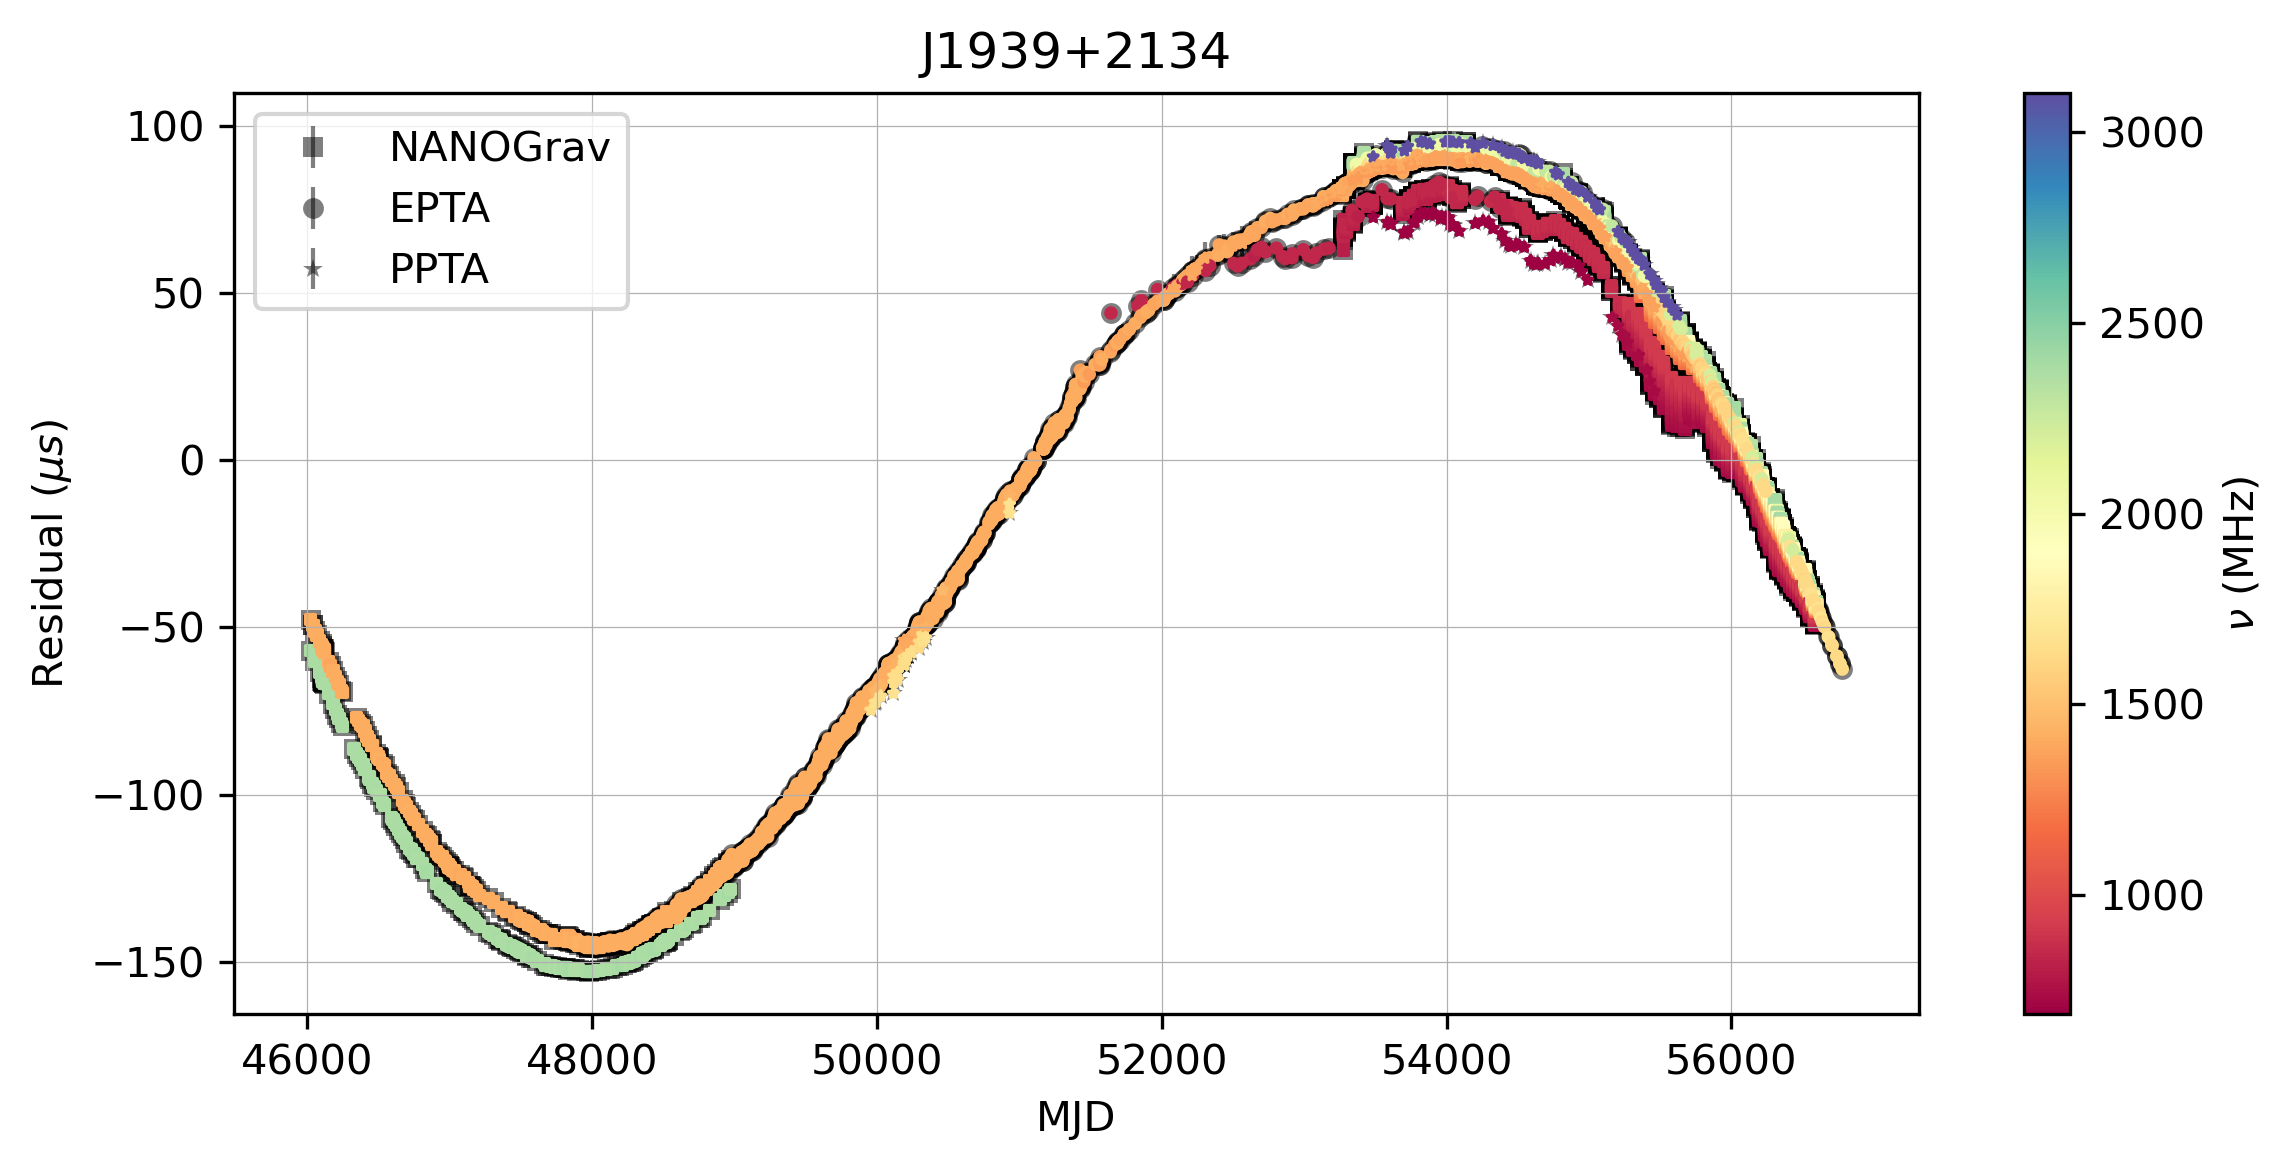

In [135]:
fig, ax = plt.subplots(figsize=(8,4))
nu_min = np.min(psr.freqs)
nu_max = np.max(psr.freqs)
for marker, pta in zip(['s','o','*'], ['NANOGrav','EPTA','PPTA']):
    if pta in psr.flags['pta']:
        mask = psr.flags['pta'] == pta
        ax.errorbar(psr.toas[mask]/const.day, psr.residuals[mask]*1e6, yerr=psr.toaerrs[mask]*1e6,
                    fmt=f'{marker}k', ms=5, marker=None, mew=0, alpha=0.5, lw=1, zorder=0, label=pta)
        sc = ax.scatter(psr.toas[mask]/const.day, psr.residuals[mask]*1e6, s=5, marker=marker,
                        c=psr.freqs[mask], cmap='Spectral', vmin=nu_min, vmax=nu_max)
cbar = plt.colorbar(sc)
cbar.set_label(r"$\nu$ (MHz)")
ax.set_xlabel("MJD")
ax.set_ylabel(r"Residual ($\mu s$)")
ax.grid(linewidth=0.3)
ax.set_title(psrname)
ax.legend()
fig.tight_layout()

since we stripped the **DM variation** model from the `.par` file, you might see some band seperation in the residuals

# setup basic enterprise model

This model is intended to correspond to the noise model used for the DR3 GWB paper:
- Timing model: Linear, use_svd
- White noise: EFACs with Gaussian priors, TNEQUAD, ECORR for NANOGrav only
- Red noise: 30-component PL from 1/Tspan
- DMv: 30-component PL from 1/Tspan
- Extra signals: DM dip for J1713 only

Possible modifications for later could include using ECORR for PPTA - this was not done in PPTA DR1 though

We'll set up the model quickly with enterprise_extensions

In [136]:
Tspan = 952746385.6296968

In [137]:
np.unique(psr.flags['group'])

array(['CPSR2_20CM', 'CPSR2_50CM', 'EFF.EBPP.1360', 'EFF.EBPP.1410',
       'JBO.DFB.1520', 'L-wide_ASP', 'L-wide_PUPPI', 'NRT.BON.1400',
       'NRT.BON.1600', 'NRT.BON.2000', 'NRT.DDS.1400', 'PDFB_10CM',
       'PDFB_20CM', 'PDFB_40CM', 'PKS.AFB.20cm_legacy',
       'PKS.cpsr2.20cm_legacy', 'PKS.fptm.20cm-legacy', 'Rcvr1_2_GASP',
       'Rcvr1_2_GUPPI', 'Rcvr_800_GASP', 'Rcvr_800_GUPPI', 'S-wide_ASP',
       'S-wide_PUPPI', 'WBCORR_10CM', 'WSRT.P1.1380', 'WSRT.P1.1380.C',
       'WSRT.P1.2273.C', 'WSRT.P1.840', 'WSRT.P1.840.C', 'kaspi14',
       'kaspi23'], dtype='<U21')

In [138]:
if 'NANOGrav' in psr.flags['pta']:
    inc_ecorr = True
    ecorr_groups_by_PTA = {'NANOGrav':'group'}
else:
    inc_ecorr = False
    ecorr_groups_by_PTA = None
efeq_groups_by_PTA = {}
for pta in np.unique(psr.flags['pta']):
    efeq_groups_by_PTA[pta] = 'group'
print(efeq_groups_by_PTA)
print(ecorr_groups_by_PTA)

{'EPTA': 'group', 'NANOGrav': 'group', 'PPTA': 'group'}
{'NANOGrav': 'group'}


In [139]:
if psr.name == 'J1713+0747':
    dm_expdip=True
else:
    dm_expdip=False

In [140]:
pta = model_singlepsr_noise(psr, Tspan=Tspan,
                            # timing
                            tm_svd=True,
                            # white noise
                            tnequad=True, inc_ecorr=inc_ecorr,
                            efeq_groups=efeq_groups_by_PTA, ecorr_groups=ecorr_groups_by_PTA,
                            log_equad_min=-10, log_equad_max=-4,
                            # DM
                            dm_var=True, dm_type='gp',
                            dmgp_kernel='diag', dm_psd='powerlaw',
                            dm_Nfreqs=30,
                            # solar wind
                            dm_sw_deter=False,
                            # dm dip
                            dm_expdip=dm_expdip, dm_expdip_basename='exp',
                            dm_expdip_tau_min=np.log10(5), dm_expdip_tau_max=np.log10(500), 
                            # red noise
                            log_A_min=-20, log_A_max=-11)

In [121]:
print(pta.summary())

enterprise v0.1.dev796+gcb3e25e,  Python v3.10.12

Signal Name                              Signal Class                   no. Parameters      
J1939+2134_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1939+2134_red_noise                     FourierBasisGP                 2                   

Basis shape (Ntoas x N basis functions): (13659, 60)
N selected toas: 13659

params:
J1939+2134_red_noise_log10_A:Uniform(pmin=-20, pmax=-11)                                  
J1939+2134_red_noise_gamma:Uniform(pmin=0, pmax=7)                                        
__________________________________________________________________________________________
J1939+2134_dm_gp                         BasisGP                        2                   

Basis shape (Ntoas x N basis functions): (13659, 60)
N selected toas: 13659

params:
J1939+2134_dm_gp_log10_A:Uniform

In [122]:
def likelihood_eval(pta):
    random_sample = {p.name:p.sample() for p in pta.params}
    return pta.get_lnlikelihood(random_sample)

In [123]:
%timeit likelihood_eval(pta)

51.9 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
# set groups for adaptive metropolis
gr = []
# group white noise parameters
pnames = pta.param_names
backends = np.unique([p[p.index('_')+1:p.index('efac')-1] for p in pnames
                      if 'efac' in p])
print(f'Backends w/ unique noise params: {backends}')
for be in backends:
    gr.append(group_from_params(pta,[f'{psrname}_{be}_']))
# group correlated noise parameters
# group red noise parameters
exclude = ['linear_timing_model','measurement_noise','tnequad',
           'ecorr_sherman-morrison','ecorr_fast-sherman-morrison']
red_signals = [p[p.index('_')+1:] for p in list(pta.signals.keys())
               if not p[p.index('_')+1:] in exclude]
rn_ct = 0
for rs in red_signals:
    if len(group_from_params(pta,[rs])) > 0:
        rn_ct += 1
        gr.append(group_from_params(pta,[rs]))
if rn_ct > 1:
    gr.append(group_from_params(pta,red_signals))
# group with all params
gr.append([i for i in range(len(pta.params))])
# save list of params corresponding to groups
for group in gr:
    print(np.array(pnames)[np.array(group)])

Backends w/ unique noise params: ['CPSR2_20CM' 'CPSR2_50CM' 'EFF.EBPP.1360' 'EFF.EBPP.1410' 'JBO.DFB.1520'
 'L-wide_ASP' 'L-wide_PUPPI' 'NRT.BON.1400' 'NRT.BON.1600' 'NRT.BON.2000'
 'NRT.DDS.1400' 'PDFB_10CM' 'PDFB_20CM' 'PDFB_40CM' 'PKS.AFB.20cm_legacy'
 'PKS.cpsr2.20cm_legacy' 'PKS.fptm.20cm-legacy' 'Rcvr1_2_GASP'
 'Rcvr1_2_GUPPI' 'Rcvr_800_GASP' 'Rcvr_800_GUPPI' 'S-wide_ASP'
 'S-wide_PUPPI' 'WBCORR_10CM' 'WSRT.P1.1380' 'WSRT.P1.1380.C'
 'WSRT.P1.2273.C' 'WSRT.P1.840' 'WSRT.P1.840.C' 'kaspi14' 'kaspi23']
['J1939+2134_CPSR2_20CM_efac' 'J1939+2134_CPSR2_20CM_log10_tnequad']
['J1939+2134_CPSR2_50CM_efac' 'J1939+2134_CPSR2_50CM_log10_tnequad']
['J1939+2134_EFF.EBPP.1360_efac' 'J1939+2134_EFF.EBPP.1360_log10_tnequad']
['J1939+2134_EFF.EBPP.1410_efac' 'J1939+2134_EFF.EBPP.1410_log10_tnequad']
['J1939+2134_JBO.DFB.1520_efac' 'J1939+2134_JBO.DFB.1520_log10_tnequad']
['J1939+2134_L-wide_ASP_efac' 'J1939+2134_L-wide_ASP_log10_ecorr'
 'J1939+2134_L-wide_ASP_log10_tnequad']
['J1939+2134_L-wide_P

Loop to get all the likelihood evaluation times!!

In [129]:
psrlist = []
psrs = glob.glob(datadir + '/J*')
for psr in psrs:
    name = psr.split('/')[-1][:-5]
    psrlist.append(name)
psrlist = np.sort(np.unique(psrlist))

In [131]:
for psrname in psrlist:
    print(psrname)
    psr = FilePulsar(f'{datadir}/{psrname}.hdf5')
    
    # groups
    if 'NANOGrav' in psr.flags['pta']:
        inc_ecorr = True
        ecorr_groups_by_PTA = {'NANOGrav':'group'}
    else:
        inc_ecorr = False
        ecorr_groups_by_PTA = None
    efeq_groups_by_PTA = {}
    for pta in np.unique(psr.flags['pta']):
        efeq_groups_by_PTA[pta] = 'group'
    
    # J1713
    if psr.name == 'J1713+0747':
        dm_expdip=True
    else:
        dm_expdip=False
    
    # get model
    pta = model_singlepsr_noise(psr,
                                # timing
                                tm_svd=True, Tspan=Tspan,
                                # white noise
                                tnequad=True, inc_ecorr=inc_ecorr,
                                efeq_groups=efeq_groups_by_PTA, ecorr_groups=ecorr_groups_by_PTA,
                                log_equad_min=-10, log_equad_max=-4,
                                # DM
                                dm_var=True, dm_type='gp',
                                dmgp_kernel='diag', dm_psd='powerlaw',
                                dm_Nfreqs=30,
                                # solar wind
                                dm_sw_deter=False,
                                # dm dip
                                dm_expdip=dm_expdip, dm_expdip_basename='exp',
                                dm_expdip_tau_min=np.log10(5), dm_expdip_tau_max=np.log10(500), 
                                # red noise
                                log_A_min=-20, log_A_max=-11)
    
    # print num params and likelihood time
    print(len(pta.params))
    %timeit likelihood_eval(pta)
    print()

J0030+0451
30
8.48 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

J0034-0534
16
1.18 ms ± 1.45 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

J0218+4232
30
2.99 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

J0437-4715
30
12.1 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

J0610-2100
10
1.91 ms ± 66.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

J0613-0200
62
30.2 ms ± 91 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

J0621+1002
26
2.08 ms ± 8.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

J0711-6830
24
1.9 ms ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

J0751+1807
22
3 ms ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

J0900-3144
14
2.02 ms ± 9.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

J1012+5307
46
42.7 ms ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

J1022+1001
38
3.94 ms ± 12.4 µs per loop (mean 

# Model 2

This is the model getting run the the noise analysis *script* on the github repo

# the sampler

Again, __[`enterprise_extensions`](https://github.com/stevertaylor/enterprise_extensions)__ has a more user friendly interface to setup a `PTMCMCSampler` instance.

## jump proposals

In [ ]:
class JumpProposal(object):

    def __init__(self, pta, snames=None):
        """Set up some custom jump proposals"""
        self.params = pta.params
        self.pnames = pta.param_names
        self.npar = len(pta.params)
        self.ndim = sum(p.size or 1 for p in pta.params)

        # parameter map
        self.pmap = {}
        ct = 0
        for p in pta.params:
            size = p.size or 1
            self.pmap[str(p)] = slice(ct, ct+size)
            ct += size

        # parameter indices map
        self.pimap = {}
        for ct, p in enumerate(pta.param_names):
            self.pimap[p] = ct

        self.snames = {}
        for sc in pta._signalcollections:
            for signal in sc._signals:
                self.snames[signal.signal_name] = signal.params


    def draw_from_prior(self, x, iter, beta):
        """Prior draw.

        The function signature is specific to PTMCMCSampler.
        """

        q = x.copy()
        lqxy = 0

        # randomly choose parameter
        idx = np.random.randint(0, self.npar)

        # if vector parameter jump in random component
        param = self.params[idx]
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[str(param)]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[idx] = param.sample()

        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[str(param)]]) - param.get_logpdf(q[self.pmap[str(param)]])

        return q, float(lqxy)

    def draw_from_red_prior(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        signal_name = 'red noise'

        # draw parameter from signal model
        param = np.random.choice(self.snames[signal_name])
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[str(param)]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[self.pmap[str(param)]] = param.sample()

        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[str(param)]]) - param.get_logpdf(q[self.pmap[str(param)]])

        return q, float(lqxy)

    def draw_from_dm_prior(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        signal_name = 'dm'

        # draw parameter from signal model
        param = np.random.choice(self.snames[signal_name])
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[str(param)]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[self.pmap[str(param)]] = param.sample()

        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[str(param)]]) - param.get_logpdf(q[self.pmap[str(param)]])

        return q, float(lqxy)

## sampling groups

In [ ]:
def get_global_parameters(pta):
    """Utility function for finding global parameters."""
    pars = []
    for sc in pta._signalcollections:
        pars.extend(sc.param_names)

    gpars = np.unique(list(filter(lambda x: pars.count(x)>1, pars)))
    ipars = np.array([p for p in pars if p not in gpars])

    return gpars, ipars


def get_parameter_groups(pta):
    """Utility function to get parameter groupings for sampling."""
    ndim = len(pta.param_names)
    groups = [range(0, ndim)]
    params = pta.param_names

    # get global and individual parameters
    gpars, ipars = get_global_parameters(pta)
    if any(gpars):
        groups.extend([[params.index(gp) for gp in gpars]])

    for sc in pta._signalcollections:
        for signal in sc._signals:
            ind = [params.index(p) for p in signal.param_names if p not in gpars]
            if ind:
                groups.extend([ind])

    return groups

## setup sampler

In [ ]:
groups = get_parameter_groups(pta)

In [ ]:
# search dimension
x0 = np.hstack(p.sample() for p in pta.params)
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

sampler = ptmcmc(ndim,
                 pta.get_lnlikelihood, pta.get_lnprior,
                 cov,
                 groups=groups,
                 outDir=outdir,
                 resume=True,
                )

outfile = os.path.join(outdir, 'params.txt')
with open(outfile, 'w') as f:
    for pname in pta.param_names:
        f.write(pname+'\n')

print(outdir)

In [ ]:
jp = JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 10)
sampler.addProposalToCycle(jp.draw_from_red_prior, 10)
sampler.addProposalToCycle(jp.draw_from_dm_prior, 10)

In [ ]:
N = int(5.0e4)

sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

# Post Processing

after the chain has gathered sufficient samples you may make some diagnostic plots and save a noisefile.

In [ ]:
def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):
    """make trace plots of chain"""
    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    """make histograms sampled parameters"""
    hist_kwargs = {
        'normed':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def make_noise_files(psrname, chain, pars, outdir='partim_bwm/'):
    """save dict of median noise parameters as .json"""
    x = {}
    for ct, par in enumerate(pars):
        x[par] = np.median(chain[:, ct])

    with open(outdir + '/{}_noise.json'.format(psrname), 'w') as fout:
        json.dump(x, fout, sort_keys=True, indent=4, separators=(',', ': '))


## read in parameter names from file

also make parameter groups for white, red, and DM noise for easier plotting

In [ ]:
with open(os.path.join(outdir, 'params.txt'), 'r') as f:
    params = [line.rstrip() for line in f]

# WN params
par_WN = []
idx_WN = []
for pp, par in enumerate(params):
    if 'efac' in par or 'equad' in par or 'ecorr' in par:
        par_WN.append(par)
        idx_WN.append(pp)

# DM params
par_DM = []
idx_DM = []
for ii, par in enumerate(params):
    if '_dm' in par:
        par_DM.append(par)
        idx_DM.append(ii)

# RN params (always last 2)
par_RN = params[-2:]
idx_RN = []
for par in par_RN:
    idx_RN.append(params.index(par))

## read in chain

make subchains for plotting groups

In [ ]:
chain_raw = pd.read_csv(os.path.join(outdir, 'chain_1.txt'),
                    sep='\t', dtype=float, header=None).values
len(chain_raw)

In [ ]:
burnfrac = 0.15
thin = 10

burn = int(burnfrac * len(chain_raw))

ch_WN = chain_raw[burn::thin, idx_WN]
ch_RN = chain_raw[burn::thin, idx_RN]
ch_DM = chain_raw[burn::thin, idx_DM]
ch_like = chain_raw[burn::thin, -4]

corL = acor(ch_like)[0]
corA = acor(ch_RN[:,1])[0]
N = len(ch_like)
print("N = {}, corL = {}, corA = {}".format(N, corL, corA))

## Plots 

### Plot RN and Likelihood samples

In [ ]:
ch_plot = np.hstack((ch_RN, ch_like.reshape(len(ch_like),1))) # RN and Likelihood chains together
par_plot = par_RN + ['log_likelihood']

hist_plot(ch_plot, par_plot, cols=3);

### Plot WN parameters

* NG pulsars have EFAC, EQUAD, and ECORR (I use 3 columns)
* other pulsars have only EFAC and EQUAD (I use 4 columns)

In [ ]:
hist_plot(ch_WN, par_WN, cols=3);

## generate noise file

This is used to fix WN parameters to their median value during GW searches.
One can also use the median noise parameters to generate a good starting location for the sampler.

In [ ]:
# save median noise parameters as JSON database
make_noise_files(psrName, chain_raw[burn::thin], params, outdir)